In [7]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join("..")))
print(os.path.abspath(os.path.join("..")))

/media/edint/64d115f7-57cc-417b-acf0-7738ac091615/Ivern/WorkSpace/CNN


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
import time
import os
import pandas as pd
import numpy as np


class FER2013Dataset(Dataset):
    """
    FER2013 CSV 데이터셋
    - columns: ['emotion', 'pixels', 'Usage']
    - pixels: 공백으로 구분된 48x48 (그레이스케일)
    - Usage: 'Training', 'PublicTest', 'PrivateTest'
    """

    def __init__(self, csv_path, usage="Training", transform=None):
        self.data = pd.read_csv(csv_path)
        self.data = self.data[self.data["Usage"] == usage].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = np.fromstring(row["pixels"], dtype=np.uint8, sep=" ").reshape(48, 48)

        # 그레이스케일(1채널) → 3채널 복제 (MobileNet 호환)
        img = np.repeat(img[..., np.newaxis], 3, axis=2)

        if self.transform:
            img = self.transform(img)

        label = int(row["emotion"])
        return img, label


def download_fer2013_dataset(
    csv_path="./data/fer2013.csv", batch_size=64, num_workers=4
):
    """
    FER2013 데이터셋 로드 함수
    - FER2013 CSV 파일은 https://www.kaggle.com/datasets/deadskull7/fer2013 에서 다운로드 가능
    """
    if not os.path.exists(csv_path):
        print(csv_path)
        print(os.getcwd())
        raise FileNotFoundError(
            f"'{csv_path}' not found. Please download fer2013.csv first."
        )

    # 이미지 전처리 정의
    # transform_train = transforms.Compose(
    #     [
    #         transforms.ToPILImage(),
    #         transforms.Resize(224),
    #         transforms.RandomHorizontalFlip(),
    #         transforms.ToTensor(),
    #         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #     ]
    # )
    transform_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])


    transform_test = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # FER2013 CSV 분할 로드
    trainset = FER2013Dataset(csv_path, usage="Training", transform=transform_train)
    valset = FER2013Dataset(csv_path, usage="PublicTest", transform=transform_test)
    testset = FER2013Dataset(csv_path, usage="PrivateTest", transform=transform_test)

    # 데이터로더 정의
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    valloader = DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    print(
        f"Loaded FER2013 dataset: train={len(trainset)} val={len(valset)} test={len(testset)}"
    )

    return {"train": trainloader, "val": valloader, "test": testloader}

class EarlyStopping:
    def __init__(self, patience=7, mode="max", min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.num_bad = 0
        self.should_stop = False

    def step(self, current):
        if self.best is None:
            self.best = current
            return False

        improved = (current - self.best) > self.min_delta if self.mode == "max" else (self.best - current) > self.min_delta
        if improved:
            self.best = current
            self.num_bad = 0
        else:
            self.num_bad += 1
            if self.num_bad >= self.patience:
                self.should_stop = True
        return self.should_stop

def compute_weights_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    y = df[df["Usage"] == "Training"]["emotion"].astype(int).values
    classes = np.arange(7)
    w = compute_class_weight(class_weight="balanced", classes=classes, y=y)
    return torch.tensor(w, dtype=torch.float32)

@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval()
    loss_sum, n = 0.0, 0
    preds, gts = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0); n += x.size(0)
        preds.extend(logits.argmax(1).cpu().numpy())
        gts.extend(y.cpu().numpy())
    loss = loss_sum / max(1, n)
    acc = accuracy_score(gts, preds)
    f1m = f1_score(gts, preds, average="macro")
    return loss, acc, f1m, np.array(gts), np.array(preds)

In [9]:
loader_dict = download_fer2013_dataset()
train_loader = loader_dict["train"]
test_loader = loader_dict["test"]
val_loader = loader_dict['val']


# FER-2013 클래스 이름
classes = ("angry", "disgust", "fear", "happy", "sad", "surprise", "neutral")

# 테스트셋에서 일부 샘플 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)


Loaded FER2013 dataset: train=28709 val=3589 test=3589


In [11]:
from mobilenet.mobilenet_3 import MobileNetV3Large

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")
model = MobileNetV3Large(num_classes=7).to(device)

class_weights = compute_weights_from_csv("./data/fer2013.csv").to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# 검증 손실 기준으로 lr 감소
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

scaler = torch.cuda.amp.GradScaler(enabled=(not "store_true") and device.type=="cuda")
early = EarlyStopping(patience=7, mode="max", min_delta=1e-4)


Device : cuda


/tmp/ipykernel_604609/3148298269.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(not "store_true") and device.type=="cuda")


In [20]:
print('Start Training...')

epochs = 100

best_f1, best_epoch = -1, -1
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs+1):
    # ---- Training ----
    model.train()
    t0 = time.time()
    run_loss, n = 0.0, 0
    
    running_loss = 0.0
    correct, total = 0, 0

    
    for x, y in tqdm.tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(enabled=scaler.is_enabled(), device_type="cpu"):
            logits = model(x)
            loss = criterion(logits, y)
        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward(); optimizer.step()
        run_loss += loss.item() * x.size(0); n += x.size(0)

    train_loss = run_loss / max(1, n)
    # ── Validation
    val_loss, val_acc, val_f1, gts, preds = evaluate(model, val_loader, device, criterion)
    scheduler.step(val_loss)

    # 체크포인트
    is_best = val_f1 > best_f1
    if is_best:
        best_f1, best_epoch = val_f1, epoch
        torch.save({"epoch": epoch,
                    "state_dict": model.state_dict(),
                    "best_val_f1": best_f1},
                    os.path.join("mobilenetv3_large_fer2013_best.pth"))
    torch.save({"epoch": epoch,
                "state_dict": model.state_dict(),
                "best_val_f1": best_f1},
                os.path.join("mobilenetv3_large_fer2013_last.pth"))

    dt = time.time() - t0
    print(f"[{epoch:03d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f} "
            f"| val_acc={val_acc:.4f} | val_f1={val_f1:.4f} | time={dt:.1f}s")

    # EarlyStopping (기준: val_f1 최대화)
    if early.step(val_f1):
        print(f"Early stopping at epoch {epoch} (best F1={best_f1:.4f} @ {best_epoch})")
        break
    
    
# ── Test (best 가중치 로드)
best_path = os.path.join("mobilenetv3_large_fer2013.pth")
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location="cpu")
    # print(ckpt.keys())
    # model.load_state_dict(torch.load("mobilenetv3_large_cifar10.pth", map_location=device))
    model.load_state_dict(ckpt)
    print(f"Loaded BEST checkpoint from epoch {epoch}")

test_loss, test_acc, test_f1, gts, preds = evaluate(model, test_loader, device, criterion)
print(f"[TEST] loss={test_loss:.4f} | acc={test_acc:.4f} | f1={test_f1:.4f}")
print(classification_report(gts, preds, target_names=classes, digits=3))

    # torch.save(model.state_dict(), "mobilenetv3_large_fer2013.pth")

Start Training...


Epoch 0/100: 100%|██████████| 449/449 [00:27<00:00, 16.56it/s]


[000] train_loss=0.9609 | val_loss=1.0471 | val_acc=0.6252 | val_f1=0.5843 | time=28.7s


Epoch 1/100: 100%|██████████| 449/449 [00:27<00:00, 16.47it/s]


[001] train_loss=0.9425 | val_loss=1.0361 | val_acc=0.6311 | val_f1=0.5922 | time=28.8s


Epoch 2/100: 100%|██████████| 449/449 [00:27<00:00, 16.38it/s]


[002] train_loss=0.9228 | val_loss=1.0333 | val_acc=0.6311 | val_f1=0.5930 | time=29.0s


Epoch 3/100: 100%|██████████| 449/449 [00:27<00:00, 16.38it/s]


[003] train_loss=0.9072 | val_loss=1.0174 | val_acc=0.6322 | val_f1=0.5966 | time=29.0s


Epoch 4/100: 100%|██████████| 449/449 [00:27<00:00, 16.38it/s]


[004] train_loss=0.8892 | val_loss=1.0247 | val_acc=0.6397 | val_f1=0.6063 | time=29.0s


Epoch 5/100: 100%|██████████| 449/449 [00:27<00:00, 16.34it/s]


[005] train_loss=0.8696 | val_loss=1.0207 | val_acc=0.6330 | val_f1=0.5980 | time=29.0s


Epoch 6/100: 100%|██████████| 449/449 [00:27<00:00, 16.37it/s]


[006] train_loss=0.8581 | val_loss=1.0172 | val_acc=0.6422 | val_f1=0.6063 | time=29.0s


Epoch 7/100: 100%|██████████| 449/449 [00:27<00:00, 16.40it/s]


[007] train_loss=0.8405 | val_loss=1.0125 | val_acc=0.6450 | val_f1=0.6074 | time=29.0s


Epoch 8/100: 100%|██████████| 449/449 [00:27<00:00, 16.38it/s]


[008] train_loss=0.8315 | val_loss=1.0096 | val_acc=0.6495 | val_f1=0.6194 | time=29.0s


Epoch 9/100: 100%|██████████| 449/449 [00:27<00:00, 16.37it/s]


[009] train_loss=0.8068 | val_loss=1.0160 | val_acc=0.6531 | val_f1=0.6284 | time=29.0s


Epoch 10/100: 100%|██████████| 449/449 [00:27<00:00, 16.31it/s]


[010] train_loss=0.8044 | val_loss=1.0353 | val_acc=0.6509 | val_f1=0.6251 | time=29.1s


Epoch 11/100: 100%|██████████| 449/449 [00:27<00:00, 16.36it/s]


[011] train_loss=0.7937 | val_loss=1.0138 | val_acc=0.6445 | val_f1=0.6073 | time=29.0s


Epoch 12/100: 100%|██████████| 449/449 [00:27<00:00, 16.42it/s]


[012] train_loss=0.7774 | val_loss=1.0200 | val_acc=0.6500 | val_f1=0.6176 | time=28.9s


Epoch 13/100: 100%|██████████| 449/449 [00:27<00:00, 16.39it/s]


[013] train_loss=0.7736 | val_loss=1.0348 | val_acc=0.6537 | val_f1=0.6218 | time=29.0s


Epoch 14/100: 100%|██████████| 449/449 [00:27<00:00, 16.30it/s]


[014] train_loss=0.7669 | val_loss=1.0275 | val_acc=0.6545 | val_f1=0.6301 | time=29.1s


Epoch 15/100: 100%|██████████| 449/449 [00:27<00:00, 16.30it/s]


[015] train_loss=0.7561 | val_loss=1.0306 | val_acc=0.6559 | val_f1=0.6282 | time=29.1s


Epoch 16/100: 100%|██████████| 449/449 [00:27<00:00, 16.36it/s]


[016] train_loss=0.7589 | val_loss=1.0263 | val_acc=0.6542 | val_f1=0.6239 | time=29.0s


Epoch 17/100: 100%|██████████| 449/449 [00:27<00:00, 16.30it/s]


[017] train_loss=0.7582 | val_loss=1.0321 | val_acc=0.6551 | val_f1=0.6274 | time=29.1s


Epoch 18/100: 100%|██████████| 449/449 [00:27<00:00, 16.35it/s]


[018] train_loss=0.7488 | val_loss=1.0404 | val_acc=0.6562 | val_f1=0.6277 | time=29.0s


Epoch 19/100: 100%|██████████| 449/449 [00:27<00:00, 16.38it/s]


[019] train_loss=0.7475 | val_loss=1.0361 | val_acc=0.6553 | val_f1=0.6288 | time=29.0s


Epoch 20/100: 100%|██████████| 449/449 [00:27<00:00, 16.34it/s]


[020] train_loss=0.7357 | val_loss=1.0362 | val_acc=0.6584 | val_f1=0.6323 | time=29.1s


Epoch 21/100: 100%|██████████| 449/449 [00:27<00:00, 16.35it/s]


[021] train_loss=0.7442 | val_loss=1.0365 | val_acc=0.6559 | val_f1=0.6285 | time=29.0s


Epoch 22/100: 100%|██████████| 449/449 [00:27<00:00, 16.31it/s]


[022] train_loss=0.7440 | val_loss=1.0365 | val_acc=0.6567 | val_f1=0.6284 | time=29.1s


Epoch 23/100: 100%|██████████| 449/449 [00:27<00:00, 16.36it/s]


[023] train_loss=0.7416 | val_loss=1.0340 | val_acc=0.6590 | val_f1=0.6325 | time=29.1s


Epoch 24/100: 100%|██████████| 449/449 [00:27<00:00, 16.32it/s]


[024] train_loss=0.7438 | val_loss=1.0389 | val_acc=0.6592 | val_f1=0.6320 | time=29.0s


Epoch 25/100: 100%|██████████| 449/449 [00:27<00:00, 16.37it/s]


[025] train_loss=0.7406 | val_loss=1.0408 | val_acc=0.6559 | val_f1=0.6290 | time=29.0s


Epoch 26/100: 100%|██████████| 449/449 [00:27<00:00, 16.37it/s]


[026] train_loss=0.7411 | val_loss=1.0422 | val_acc=0.6562 | val_f1=0.6304 | time=29.0s


Epoch 27/100: 100%|██████████| 449/449 [00:27<00:00, 16.37it/s]


[027] train_loss=0.7321 | val_loss=1.0397 | val_acc=0.6565 | val_f1=0.6313 | time=29.0s


Epoch 28/100: 100%|██████████| 449/449 [00:27<00:00, 16.37it/s]


[028] train_loss=0.7394 | val_loss=1.0429 | val_acc=0.6578 | val_f1=0.6289 | time=29.0s


Epoch 29/100: 100%|██████████| 449/449 [00:27<00:00, 16.27it/s]


[029] train_loss=0.7326 | val_loss=1.0453 | val_acc=0.6609 | val_f1=0.6324 | time=29.1s


Epoch 30/100: 100%|██████████| 449/449 [00:27<00:00, 16.35it/s]


[030] train_loss=0.7365 | val_loss=1.0444 | val_acc=0.6581 | val_f1=0.6328 | time=29.1s


Epoch 31/100: 100%|██████████| 449/449 [00:27<00:00, 16.36it/s]


[031] train_loss=0.7407 | val_loss=1.0423 | val_acc=0.6576 | val_f1=0.6297 | time=29.0s


Epoch 32/100: 100%|██████████| 449/449 [00:27<00:00, 16.27it/s]


[032] train_loss=0.7392 | val_loss=1.0395 | val_acc=0.6567 | val_f1=0.6302 | time=29.2s


Epoch 33/100: 100%|██████████| 449/449 [00:27<00:00, 16.34it/s]


[033] train_loss=0.7418 | val_loss=1.0431 | val_acc=0.6609 | val_f1=0.6335 | time=29.1s


Epoch 34/100: 100%|██████████| 449/449 [00:27<00:00, 16.39it/s]


[034] train_loss=0.7310 | val_loss=1.0477 | val_acc=0.6590 | val_f1=0.6329 | time=28.9s


Epoch 35/100: 100%|██████████| 449/449 [00:27<00:00, 16.36it/s]


[035] train_loss=0.7437 | val_loss=1.0360 | val_acc=0.6604 | val_f1=0.6311 | time=29.0s


Epoch 36/100: 100%|██████████| 449/449 [00:27<00:00, 16.34it/s]


[036] train_loss=0.7404 | val_loss=1.0416 | val_acc=0.6567 | val_f1=0.6308 | time=29.0s


Epoch 37/100: 100%|██████████| 449/449 [00:27<00:00, 16.30it/s]


[037] train_loss=0.7468 | val_loss=1.0448 | val_acc=0.6612 | val_f1=0.6342 | time=29.2s


Epoch 38/100: 100%|██████████| 449/449 [00:27<00:00, 16.30it/s]


[038] train_loss=0.7395 | val_loss=1.0422 | val_acc=0.6584 | val_f1=0.6332 | time=29.1s


Epoch 39/100: 100%|██████████| 449/449 [00:27<00:00, 16.34it/s]


[039] train_loss=0.7399 | val_loss=1.0420 | val_acc=0.6592 | val_f1=0.6319 | time=29.0s


Epoch 40/100: 100%|██████████| 449/449 [00:27<00:00, 16.33it/s]


[040] train_loss=0.7373 | val_loss=1.0428 | val_acc=0.6592 | val_f1=0.6333 | time=29.0s


Epoch 41/100: 100%|██████████| 449/449 [00:27<00:00, 16.32it/s]


[041] train_loss=0.7400 | val_loss=1.0370 | val_acc=0.6573 | val_f1=0.6304 | time=29.0s


Epoch 42/100: 100%|██████████| 449/449 [00:27<00:00, 16.29it/s]


[042] train_loss=0.7350 | val_loss=1.0422 | val_acc=0.6587 | val_f1=0.6315 | time=29.1s


Epoch 43/100: 100%|██████████| 449/449 [00:27<00:00, 16.29it/s]


[043] train_loss=0.7385 | val_loss=1.0441 | val_acc=0.6559 | val_f1=0.6294 | time=29.1s


Epoch 44/100: 100%|██████████| 449/449 [00:27<00:00, 16.26it/s]


[044] train_loss=0.7416 | val_loss=1.0380 | val_acc=0.6595 | val_f1=0.6314 | time=29.1s
Early stopping at epoch 44 (best F1=0.6342 @ 37)
Loaded BEST checkpoint from epoch 44
[TEST] loss=2.7479 | acc=0.6367 | f1=0.6226
              precision    recall  f1-score   support

       angry      0.548     0.542     0.545       491
     disgust      0.800     0.509     0.622        55
        fear      0.472     0.498     0.485       528
       happy      0.856     0.862     0.859       879
         sad      0.477     0.517     0.496       594
    surprise      0.820     0.714     0.763       416
     neutral      0.588     0.585     0.587       626

    accuracy                          0.637      3589
   macro avg      0.652     0.604     0.623      3589
weighted avg      0.643     0.637     0.639      3589



ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

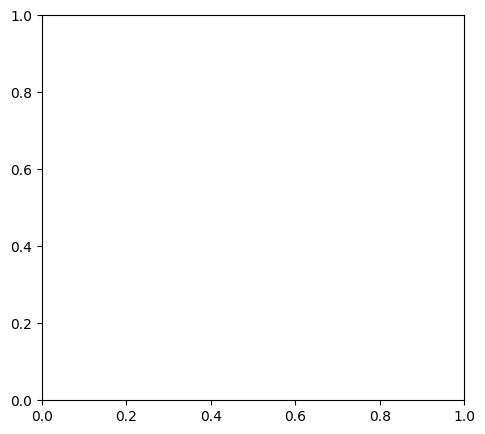

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, 'o-', label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, 's--', label='Val Loss')
plt.title('Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accs, 'o-', label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accs, 's--', label='Val Accuracy')
plt.title('Accuracy Trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()